In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.gridspec import GridSpec
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [2]:
train = pd.read_csv("/kaggle/input/inputdata/train.csv")
test = pd.read_csv("/kaggle/input/inputdata/test.csv")

In [3]:
train[:5]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
test[:5]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [5]:
#将目标从x转移到log(x + 1)
for col in ['casual', 'registered', 'count']:
    train['%s_log' % col] = np.log(train[col] + 1)

In [6]:
#从时间戳中提取信息
train_date = pd.DatetimeIndex(train['datetime'])
train['year'] = train_date.year
train['month'] = train_date.month
train['hour'] = train_date.hour
train['dayofweek'] = train_date.dayofweek
test_date = pd.DatetimeIndex(test['datetime'])
test['year'] = test_date.year
test['month'] = test_date.month
test['hour'] = test_date.hour
test['dayofweek'] = test_date.dayofweek

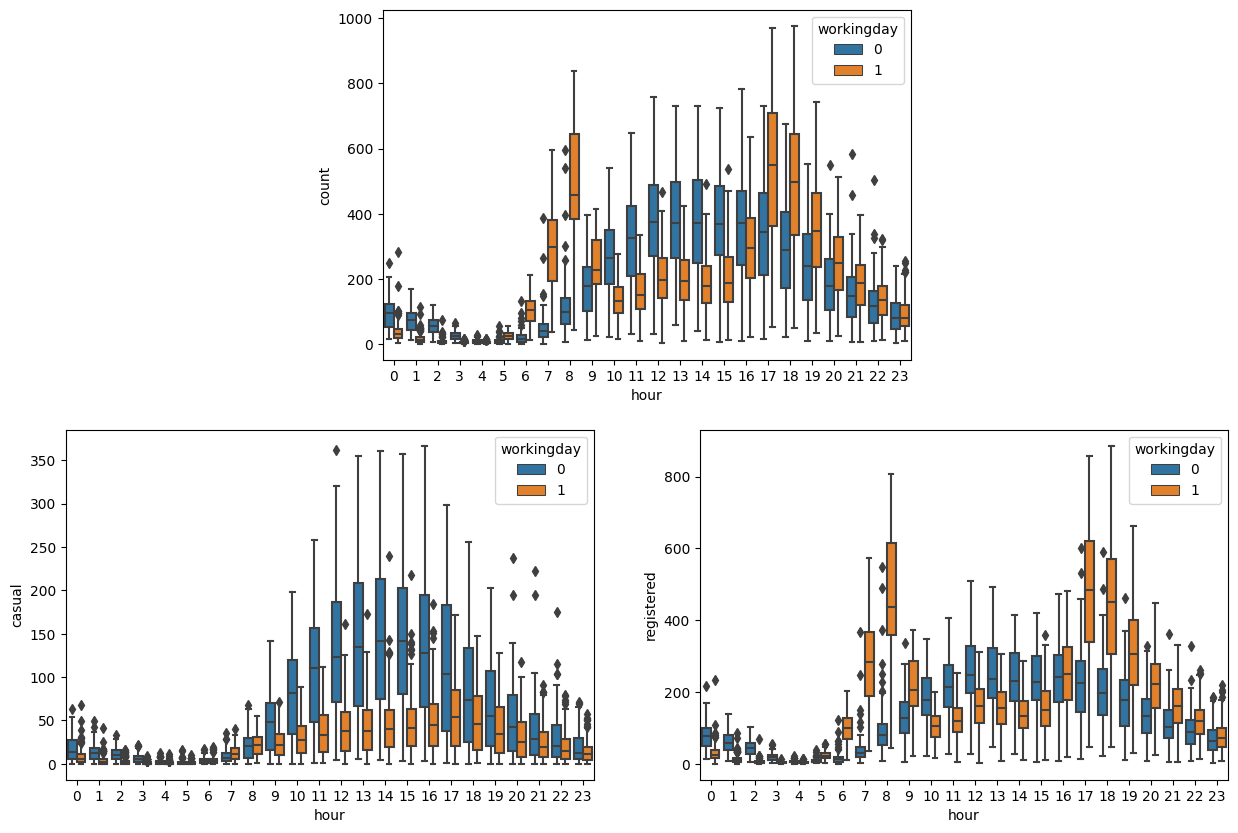

In [7]:
#新特征
#非注册用户:白天出租更多  
#注册用户:上班/下班时租金更高 
fig = plt.figure(figsize=(15, 10))
gs1 = GridSpec(4, 4, fig, wspace=0.5, hspace=0.5)
plt.subplot(gs1[:2, 1:3])
sns.boxplot(x='hour', y='count', hue='workingday', data=train)
plt.subplot(gs1[2:, :2])
sns.boxplot(x='hour', y='casual', hue='workingday', data=train)
plt.subplot(gs1[2:, 2:])
sns.boxplot(x='hour', y='registered', hue='workingday', data=train)
plt.show()

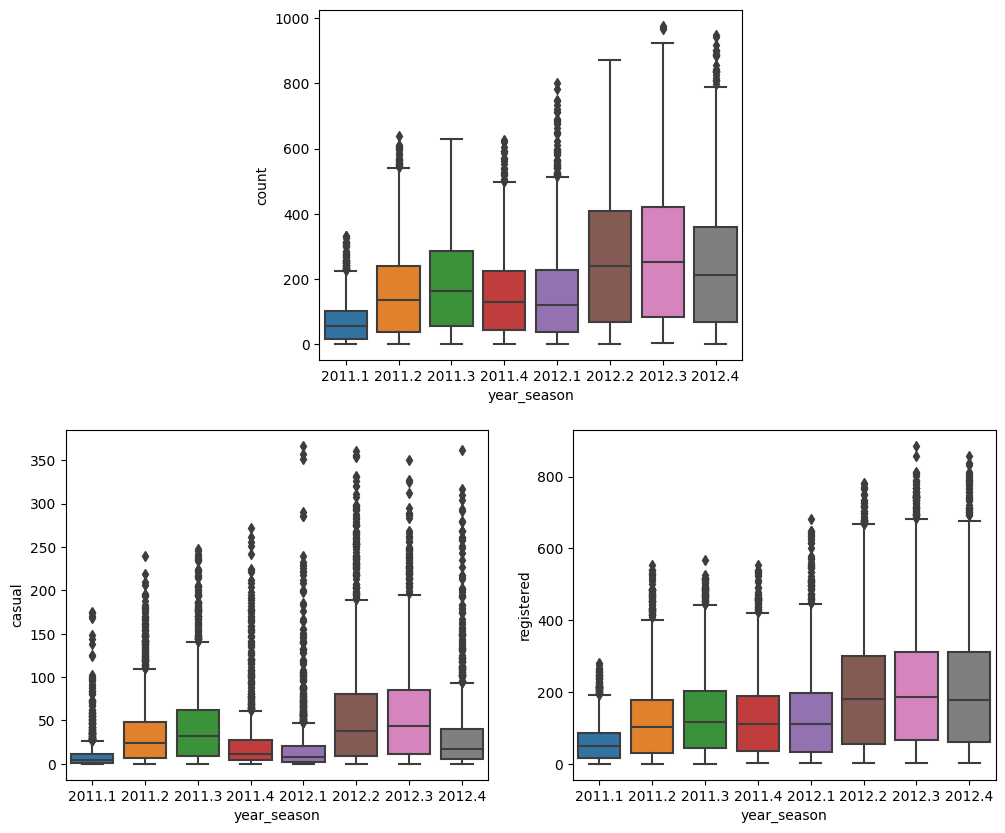

In [8]:
#新特征 
#结合年份和季节 
train['year_season'] = train_date.year + train.season / 10
fig = plt.figure(figsize=(12, 10))
gs1 = GridSpec(4, 4, fig, wspace=0.5, hspace=0.5)
plt.subplot(gs1[:2, 1:3])
sns.boxplot(x='year_season', y='count', data=train)
plt.subplot(gs1[2:, :2])
sns.boxplot(x='year_season', y='casual', data=train)
plt.subplot(gs1[2:, 2:])
sns.boxplot(x='year_season', y='registered', data=train)
plt.show()

In [9]:
# 新特征
for df in [train, test]:
    df['year_season'] = df['year'] + df['season'] / 10
    df['hour_workingday_casual'] = df[['hour', 'workingday']].apply(
        lambda x: int(10 <= x['hour'] <= 19), axis=1)
    df['hour_workingday_registered'] = df[['hour', 'workingday']].apply(
      lambda x: int(
        (x['workingday'] == 1 and (x['hour'] == 8 or 17 <= x['hour'] <= 18))
        or (x['workingday'] == 0 and 10 <= x['hour'] <= 19)), axis=1)

by_season = train.groupby('year_season')[['count']].median()
by_season.columns = ['count_season']
train = train.join(by_season, on='year_season')
test = test.join(by_season, on='year_season')

In [10]:
# RandomForestRegressor
features = ['season', 'holiday', 'workingday', 'weather',
            'temp', 'atemp', 'humidity', 'windspeed',
            'year', 'hour', 'dayofweek', 'hour_workingday_casual', 'count_season']
reg = RandomForestRegressor(n_estimators=900, min_samples_leaf=2, random_state=0, n_jobs=-1)
reg.fit(train[features], train['casual_log'])
pred_casual = reg.predict(test[features])
pred_casual = np.exp(pred_casual) - 1
pred_casual[pred_casual < 0] = 0
features = ['season', 'holiday', 'workingday', 'weather',
            'temp', 'atemp', 'humidity', 'windspeed',
            'year', 'hour', 'dayofweek', 'hour_workingday_registered', 'count_season']
reg = RandomForestRegressor(n_estimators=900, min_samples_leaf=2, random_state=0, n_jobs=-1)
reg.fit(train[features], train['registered_log'])
pred_registered = reg.predict(test[features])
pred_registered = np.exp(pred_registered) - 1
pred_registered[pred_registered < 0] = 0
pred2 = pred_casual + pred_registered

In [11]:
# RandomForestRegressor
submission = pd.DataFrame({'datetime':test.datetime, 'count':pred2},
                          columns = ['datetime', 'count'])
submission.to_csv("/kaggle/working/submission.csv", index=False)

{'n_estimators': 900}


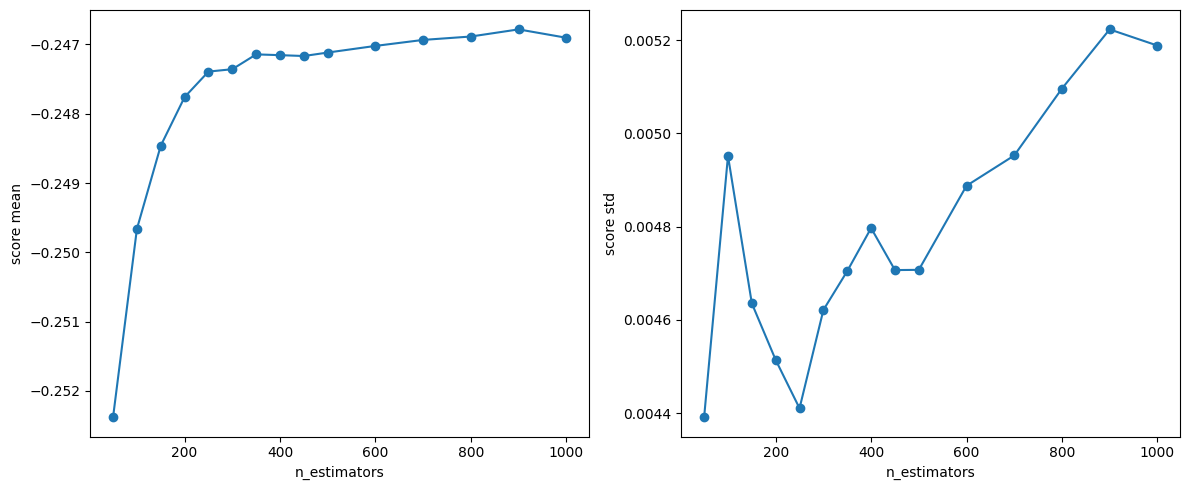

In [ ]:
# RandomForestRegressor
# larger n_estimators better
def plot_cv(param, bestreg, variable):
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(param[variable], bestreg.cv_results_['mean_test_score'], 'o-')
    plt.xlabel(variable)
    plt.ylabel("score mean")
    plt.subplot(122)
    plt.plot(param[variable], bestreg.cv_results_['std_test_score'], 'o-')
    plt.xlabel(variable)
    plt.ylabel("score std")
    plt.tight_layout()
    plt.show()

year_month = train['year'] * 100 + train['month']
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

reg = RandomForestRegressor(random_state=0, n_jobs=-1)
param = {"n_estimators": [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000]}
bestreg = GridSearchCV(reg, param, cv=kf.split(train, year_month), scoring='neg_mean_squared_error')
bestreg.fit(train[features], train['casual_log'])
print(bestreg.best_params_)
plot_cv(param, bestreg, "n_estimators")

reg = RandomForestRegressor(random_state=0, n_jobs=-1)
param = {"n_estimators": [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000]}
bestreg = GridSearchCV(reg, param, cv=kf.split(train, year_month), scoring='neg_mean_squared_error')
bestreg.fit(train[features], train['registered_log'])
print(bestreg.best_params_)
plot_cv(param, bestreg, "n_estimators")

In [ ]:
# RandomForestRegressor
# tune min_samples_leaf
reg = RandomForestRegressor(n_estimators=900, random_state=0, n_jobs=-1)
param = {"min_samples_leaf": np.arange(1, 10, 1)}
bestreg = GridSearchCV(reg, param, cv=kf.split(train, year_month), scoring='neg_mean_squared_error')
bestreg.fit(train[features], train['casual_log'])
print(bestreg.best_params_)
plot_cv(param, bestreg, "min_samples_leaf")

reg = RandomForestRegressor(n_estimators=900, random_state=0, n_jobs=-1)
param = {"min_samples_leaf": np.arange(1, 10, 1)}
bestreg = GridSearchCV(reg, param, cv=kf.split(train, year_month), scoring='neg_mean_squared_error')
bestreg.fit(train[features], train['registered_log'])
print(bestreg.best_params_)
plot_cv(param, bestreg, "min_samples_leaf")

In [ ]:
# GradientBoostingRegressor  
features = ['season', 'holiday', 'workingday', 'weather',
            'temp', 'atemp', 'humidity', 'windspeed',
            'year', 'hour', 'dayofweek', 'hour_workingday_casual', 'count_season']
reg = GradientBoostingRegressor(n_estimators=1000, min_samples_leaf=6, random_state=0)
reg.fit(train[features], train['casual_log'])
pred_casual = reg.predict(test[features])
pred_casual = np.exp(pred_casual) - 1
pred_casual[pred_casual < 0] = 0
features = ['season', 'holiday', 'workingday', 'weather',
            'temp', 'atemp', 'humidity', 'windspeed',
            'year', 'hour', 'dayofweek', 'hour_workingday_registered', 'count_season']
reg = GradientBoostingRegressor(n_estimators=1000, min_samples_leaf=6, random_state=0)
reg.fit(train[features], train['registered_log'])
pred_registered = reg.predict(test[features])
pred_registered = np.exp(pred_registered) - 1
pred_registered[pred_registered < 0] = 0
pred1 = pred_casual + pred_registered

In [ ]:
# GradientBoostingRegressor
# larger n_estimators better
def plot_cv(param, bestreg, variable):
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(param[variable], bestreg.cv_results_['mean_test_score'], 'o-')
    plt.xlabel(variable)
    plt.ylabel("score mean")
    plt.subplot(122)
    plt.plot(param[variable], bestreg.cv_results_['std_test_score'], 'o-')
    plt.xlabel(variable)
    plt.ylabel("score std")
    plt.tight_layout()
    plt.show()

year_month = train['year'] * 100 + train['month']
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

reg = GradientBoostingRegressor(random_state=0)
param = {"n_estimators": [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000]}
bestreg = GridSearchCV(reg, param, cv=kf.split(train, year_month), scoring='neg_mean_squared_error')
bestreg.fit(train[features], train['casual_log'])
print(bestreg.best_params_)
plot_cv(param, bestreg, "n_estimators")

reg = GradientBoostingRegressor(random_state=0)
param = {"n_estimators": [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000]}
bestreg = GridSearchCV(reg, param, cv=kf.split(train, year_month), scoring='neg_mean_squared_error')
bestreg.fit(train[features], train['registered_log'])
print(bestreg.best_params_)
plot_cv(param, bestreg, "n_estimators")

In [ ]:
# GradientBoostingRegressor
# tune min_samples_leaf
reg = GradientBoostingRegressor(n_estimators=1000, random_state=0)
param = {"min_samples_leaf": np.arange(1, 10, 1)}
bestreg = GridSearchCV(reg, param, cv=kf.split(train, year_month), scoring='neg_mean_squared_error')
bestreg.fit(train[features], train['casual_log'])
print(bestreg.best_params_)
plot_cv(param, bestreg, "min_samples_leaf")

reg = GradientBoostingRegressor(n_estimators=1000, random_state=0)
param = {"min_samples_leaf": np.arange(1, 10, 1)}
bestreg = GridSearchCV(reg, param, cv=kf.split(train, year_month), scoring='neg_mean_squared_error')
bestreg.fit(train[features], train['registered_log'])
print(bestreg.best_params_)
plot_cv(param, bestreg, "min_samples_leaf")

In [ ]:
#俩个模型合一起
pred = 0.5 * pred1 + 0.5 * pred2
submission = pd.DataFrame({'datetime':test.datetime, 'count':pred},
                          columns = ['datetime', 'count'])
submission.to_csv("submission/submission_3.csv", index=False)